# Imports

In [5]:
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
import time
from torch_fidelity import calculate_metrics
import numpy as np
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [45]:
import wandb
run = wandb.init()
artifact = run.use_artifact('gioeba-free-university-of-tbilisi-/GenModels_Final_NCSN_CIFAR-10/model_epoch_80:v3', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact 'model_epoch_80:v3', 224.48MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:03.8 (59.3MB/s)


# Config

In [7]:
BATCH_SIZE = 64
NUM_NOISE_LEVELS = 10
LEARNING_RATE = 1e-3
LANGEVIN_STEP_EPS = 2e-5
NUM_FILTERS = 128
EMA_DECAY = 0.999

In [8]:
SNAP_PATH = "/tmp/snaps"
os.makedirs(SNAP_PATH, exist_ok=True)

# Dataset

In [9]:
transform = T.Compose([
    T.ToTensor(),
    #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def utransform(img):
    return img

In [10]:
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:03<00:00, 45.2MB/s] 


In [11]:
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"Num batches per epoch: {len(loader)}")

Num batches per epoch: 782


In [12]:
real_folder = "/tmp/cifar10_real"
gen_folder = "/tmp/cifar10_gen"
os.makedirs(real_folder, exist_ok=True)
os.makedirs(gen_folder, exist_ok=True)

if len(os.listdir(real_folder)) == 0:
    print("Saving real CIFAR-10 images...")
    for i in tqdm(range(10000)):
        img, _ = dataset[i]
        vutils.save_image(img, os.path.join(real_folder, f"{i+1}.png"))
else:
    print("Real images already exist, skipping.")

Saving real CIFAR-10 images...


100%|██████████| 10000/10000 [00:07<00:00, 1379.32it/s]


In [13]:
def imshow(img):
    # Convert from Tensor (C, H, W) to Numpy (H, W, C)
    npimg = utransform(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

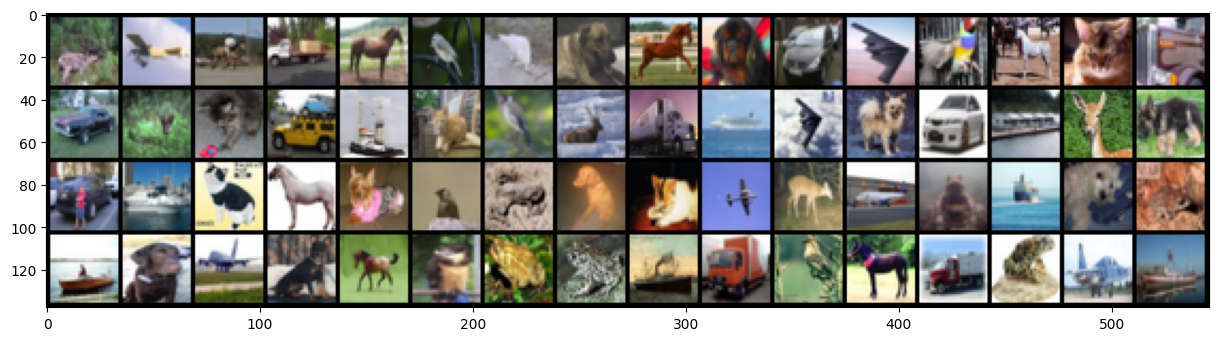

In [14]:
# Sample a batch and display it in a grid
dataiter = iter(loader)
images, labels = next(dataiter)

grid_img = torchvision.utils.make_grid(images, nrow=16)

plt.figure(figsize=(15, 15))
imshow(grid_img)

## Model Architecture

### Conditional Instance Norm++ (Paper's implementation)

In [15]:
# Disclaimer: the implementation of CondInstanceNormPlusPlus based on the following code:
# https://github.com/DanyeongLee/ncsn-pytorch/blob/main/src/layers.py#L5
# I modified the implementation to fit my project

class CondInstanceNormPlusPlus(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.eps = 1e-5
        
        self.alpha = nn.Parameter(torch.zeros(NUM_NOISE_LEVELS, in_channels))
        self.beta = nn.Parameter(torch.zeros(NUM_NOISE_LEVELS, in_channels))
        self.gamma = nn.Parameter(torch.ones(NUM_NOISE_LEVELS, in_channels))

    def forward(self, x, noise_level):

        num_channels = x.shape[0]
        alpha = self.alpha[noise_level].view(num_channels, -1, 1, 1)
        beta = self.beta[noise_level].view(num_channels, -1, 1, 1)
        gamma = self.gamma[noise_level].view(num_channels, -1, 1, 1)

        # This is just regular InstanceNorm
        mu = x.mean(dim=(2, 3), keepdim=True)
        var = x.var(dim=(2, 3), keepdim=True)
        sigma = torch.sqrt(var + self.eps)
        
        x = (x - mu) / sigma
        x = gamma * x + beta
        #####
        
        m = mu.mean(dim=1, keepdim=True)
        s = torch.ones_like(mu)
        if mu.shape[1] > 1:
            v = mu.var(dim=1, keepdim=True)
            s = torch.sqrt(v + self.eps)

        x = x + alpha * (mu - m) / s
        
        return x

### Conditional Refine Net

In [16]:
# ChainedResidualPooling(CRP) 2-stage implementation
# Captures background context and adds to the detailed features
class ChainedResidualPooling(nn.Module):
    def __init__(self, features):
        super().__init__()

        self.norm1 = CondInstanceNormPlusPlus(features)
        self.conv1 = nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=False)

        self.norm2 = CondInstanceNormPlusPlus(features)
        self.conv2 = nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=False)

        self.pool = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)

        self.act = nn.ELU()

    def forward(self, x, noise_level):
        h = self.act(x)

        result = h

        # Stage-1
        h = self.norm1(h, noise_level)
        h = self.act(h)
        h = self.pool(h)
        h = self.conv1(h)
        result = result + h # Important not to use += inplace operation

        # Stage-2
        h = self.norm2(h, noise_level)
        h = self.act(h)
        h = self.pool(h)
        h = self.conv2(h)
        result = result + h

        return result

# Multi Resolution Fusion(MRF) MRF ensures the model draws sharp details in the correct places.
class MultiResolutionFusion(nn.Module):
    def __init__(self, inputs, out_features):
        super().__init__()

        self.num_inputs = len(inputs)
        self.out_features = out_features

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        for i in range(self.num_inputs):
            self.convs.append(
                nn.Conv2d(inputs[i], out_features, kernel_size=3, stride=1, padding=1, bias=True)
            )
            self.norms.append(CondInstanceNormPlusPlus(inputs[i]))

    def forward(self, xs, noise_level, output_shape):
        B = xs[0].shape[0]
        C = self.out_features
        H, W = output_shape
        result = torch.zeros(B, C, H, W, device=device)
        
        for i in range(len(self.convs)):
            h = self.norms[i](xs[i], noise_level)
            h = self.convs[i](h)
            h = F.interpolate(h, size=output_shape, mode='bilinear', align_corners=True)
            result += h
        
        return result


# 2-stage Conditional Residual Convolution Unit(RCU) block
class RCU(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super().__init__()
        
        self.norm1 = CondInstanceNormPlusPlus(channels)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same')
        
        self.norm2 = CondInstanceNormPlusPlus(channels)        
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same')
        
        self.act = nn.ELU()

    def forward(self, x, noise_level):
        h = self.norm1(x, noise_level)
        h = self.act(h)
        h = self.conv1(h)

        h = self.norm2(h, noise_level)
        h = self.act(h)
        h = self.conv2(h)
        
        return x + h


class RCUBlock2(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = RCU(in_channels)
        self.conv2 = RCU(in_channels)

    def forward(self, x, noise_level):
        h = self.conv1(x, noise_level)
        h = self.conv2(h, noise_level)
        return h


class RCUBlock3(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = RCU(in_channels)
        self.conv2 = RCU(in_channels)
        self.conv3 = RCU(in_channels)

    def forward(self, x, noise_level):
        h = self.conv1(x, noise_level)
        h = self.conv2(h, noise_level)
        h = self.conv3(h, noise_level)
        return h


class CondRefineBlock(nn.Module):
    def __init__(self, inputs, out_features, last=False):
        super().__init__()

        self.num_inputs = len(inputs)
        
        self.adaptive_layers = nn.ModuleList()
        for i in range(self.num_inputs):
            self.adaptive_layers.append(
                RCUBlock2(inputs[i])
            )

        self.mrf = None
        # Resolution change may be required if we have multiple inputs
        if self.num_inputs > 1:
            self.mrf = MultiResolutionFusion(inputs, out_features)
            
        self.crp = ChainedResidualPooling(out_features)

        if last:
            # Give extra depth to resolve artifacts and other problems since this is a last RefineNet layer
            self.end = RCUBlock3(out_features)
        else:
            self.end = RCU(out_features)

    def forward(self, xs, noise_level, output_shape):
        hs = []
        for i in range(len(xs)):
            h = self.adaptive_layers[i](xs[i], noise_level)
            hs.append(h)

        if self.mrf != None:
            h = self.mrf(hs, noise_level, output_shape)
        else:
            h = hs[0]

        h = self.crp(h, noise_level)
        h = self.end(h, noise_level)

        return h

### Conditional Residual Blocks

In [17]:
class CondResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.norm1 = CondInstanceNormPlusPlus(channels)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding='same')

        self.norm2 = CondInstanceNormPlusPlus(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding='same')
        
        self.act = nn.ELU()

    def forward(self, x, noise_level):
        out = self.norm1(x, noise_level)
        out = self.act(out)
        out = self.conv1(out)

        out = self.norm2(out, noise_level)
        out = self.act(out)
        out = self.conv2(out)
        
        return x + out

class CondResBlockDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.norm1 = CondInstanceNormPlusPlus(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        self.norm2 = CondInstanceNormPlusPlus(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        self.pool = nn.AvgPool2d(2) # Downsampler
        self.act = nn.ELU()

        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.AvgPool2d(2)
        )

    def forward(self, x, noise_level):
        h = self.norm1(x, noise_level)
        h = self.act(h)
        h = self.conv1(h)
        
        h = self.norm2(h, noise_level)
        h = self.act(h)
        h = self.conv2(h)
        h = self.pool(h)

        shortcut = self.shortcut(x)
        
        return shortcut + h

class CondResBlockDilation(nn.Module):
    def __init__(self, channels, dilation):
        super().__init__()
        self.norm1 = CondInstanceNormPlusPlus(channels)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=dilation, dilation=dilation, bias=True)

        self.norm2 = CondInstanceNormPlusPlus(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=dilation, dilation=dilation, bias=True)
        
        self.act = nn.ELU()

    def forward(self, x, noise_level):
        h = self.norm1(x, noise_level)
        h = self.act(h)
        h = self.conv1(h)
        
        h = self.norm2(h, noise_level)
        h = self.act(h)
        h = self.conv2(h)
    
        return x + h

### NCSN Class Implementation

In [18]:
class NCSN(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.act = nn.ELU()
        self.begin = nn.Conv2d(in_channels=3, out_channels=NUM_FILTERS, kernel_size=3, stride=1, padding=1)
        
        self.res1 = nn.ModuleList([
            CondResBlock(NUM_FILTERS),
            CondResBlock(NUM_FILTERS),
        ])
        
        self.res2 = nn.ModuleList([
            CondResBlockDownsample(NUM_FILTERS, 2*NUM_FILTERS),
            CondResBlock(2*NUM_FILTERS),
        ])

        self.res3 = nn.ModuleList([
            CondResBlockDilation(2*NUM_FILTERS, dilation=2),
            CondResBlockDilation(2*NUM_FILTERS, dilation=2),
        ])

        self.res4 = nn.ModuleList([
            CondResBlockDilation(2*NUM_FILTERS, dilation=4),
            CondResBlockDilation(2*NUM_FILTERS, dilation=4),
        ])

        self.refine1 = CondRefineBlock([2 * NUM_FILTERS], 2 * NUM_FILTERS)
        self.refine2 = CondRefineBlock([2 * NUM_FILTERS, 2 * NUM_FILTERS], 2 * NUM_FILTERS)
        self.refine3 = CondRefineBlock([2 * NUM_FILTERS, 2 * NUM_FILTERS], NUM_FILTERS)
        self.refine4 = CondRefineBlock([NUM_FILTERS, NUM_FILTERS], NUM_FILTERS, last=True)

        self.norm = CondInstanceNormPlusPlus(NUM_FILTERS)
        self.end = nn.Conv2d(in_channels=NUM_FILTERS, out_channels=3, kernel_size=3, stride=1, padding=1)

    def res_forward(self, module, x, y):
        for m in module:
            x = m(x, y)
        return x
        
    def forward(self, x, noise_level):
        x1 = self.begin(x)
        
        h1 = self.res_forward(self.res1, x1, noise_level)
        h2 = self.res_forward(self.res2, h1, noise_level)
        h3 = self.res_forward(self.res3, h2, noise_level)
        h4 = self.res_forward(self.res4, h3, noise_level)
        
        ref1 = self.refine1([h4], noise_level, h4.shape[2:])
        ref2 = self.refine2([h3, ref1], noise_level, h3.shape[2:])
        ref3 = self.refine3([h2, ref2], noise_level, h2.shape[2:])
        ref4 = self.refine4([h1, ref3], noise_level, h1.shape[2:])
        
        out = self.norm(ref4, noise_level)
        out = self.act(out)
        out = self.end(out)
        
        return out

# Training

In [19]:
class Model:
    def __init__(self):
        self.model = NCSN().to(device)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        
        self.noise_levels = torch.linspace(1.0, 0.01, NUM_NOISE_LEVELS).to(device)
        self.ema_params = [param.clone().detach() for param in self.model.parameters()]
        print(self.noise_levels)

        
    def score_matching_loss(self, x):
        B = x.shape[0]
        
        # Pick some random noise level
        idx = torch.randint(0, len(self.noise_levels), (B,), device=device)
        sigma = self.noise_levels[idx].view(-1, 1, 1, 1)

        # Add gaussian noise of level sigma
        noise = torch.randn_like(x)
        x_noisy = x + sigma * noise

        # Predict score
        score = self.model(x_noisy, idx)

        loss = F.mse_loss(sigma * score, -noise)
        
        return loss


    def langevin_step(self, x, step_size, idx):
        # Get scores
        score = self.model(x, idx)
        
        # Take a step
        noise = torch.randn_like(x)
        
        # x = current_x + drift(Gradient Ascent) + noisy step
        x = x + step_size * score / 2 + torch.sqrt(step_size) * noise
            
        return x


    def sample(self, n, steps=100):
        self.model.eval()

        # Initialize random points
        shape = (n, 3, 32, 32) # (num_images, rgb, w, h)
        x = torch.rand(shape).to(device)

        with torch.no_grad():
            # Backup original model params
            original_params = [p.clone().detach() for p in self.model.parameters()]
            
            # Load in EMA params
            for p, ema_p in zip(self.model.parameters(), self.ema_params):
                p.copy_(ema_p)
        
            for i in tqdm(range(NUM_NOISE_LEVELS)):
                idx = torch.full((n,), i, dtype=torch.long, device=device)

                sigma_i = self.noise_levels[i]
                sigma_L = self.noise_levels[-1]
                
                step_size = LANGEVIN_STEP_EPS * (sigma_i / sigma_L) ** 2
                
                for _ in range(steps):
                    x = self.langevin_step(x, step_size, idx)

            # Restore the original params
            for p, orig_p in zip(self.model.parameters(), original_params):
                p.copy_(orig_p)

        return x
    
    def train_step(self, x):
        self.model.train()
        
        x = x.to(device)
        
        self.opt.zero_grad()
        
        loss = self.score_matching_loss(x)

        # Backpropagation
        loss.backward()
        self.opt.step()

        loss_amount = loss.item()

        # EMA
        with torch.no_grad():
            for param, ema_param in zip(self.model.parameters(), self.ema_params):
                ema_param.copy_(EMA_DECAY * ema_param + (1.0 - EMA_DECAY) * param)

        # Return single train step loss
        return loss_amount

    def train_one_epoch(self, loader):
        epoch_loss = 0
        for i, (x, _) in enumerate(tqdm(loader)):
            epoch_loss += self.train_step(x)
        epoch_loss = epoch_loss / len(loader)
        return epoch_loss


In [20]:
def save_images(samples):
    samples = samples.clamp(0, 1).cpu()
    
    for i in range(samples.shape[0]):
        img_tensor = samples[i]
        img = to_pil_image(img_tensor)
        img.save(os.path.join(gen_folder, f"{i+1}.png"))

In [21]:
from torchvision.transforms.functional import to_pil_image

def show_samples(samples):
    samples = torch.clamp(samples, 0.0, 1.0)
    grid = vutils.make_grid(samples, nrow=4)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

In [22]:
def save_snapshot(m, epoch):
    name = f"{SNAP_PATH}/model_epoch{epoch}.pt"

    # Create a dictionary for EMA weights mapping names to tensors
    # This makes it compatible with .load_state_dict() later
    ema_state_dict = {}
    if hasattr(m, 'ema_params'):
        # We pair the names from the actual model with the tensors in the EMA list
        param_names = list(m.model.state_dict().keys())
        ema_state_dict = {name: p for name, p in zip(param_names, m.ema_params)}
    
    torch.save({
        "model": m.model.state_dict(),
        "ema": ema_state_dict,
    }, name)
    
    return name

In [29]:
def load_snapshot(m, path):
    ckpt = torch.load(path, map_location="cpu")
    m.model.load_state_dict(ckpt["ema"])
    m.ema_params = [param.clone().detach() for param in m.model.parameters()]
    m.model.load_state_dict(ckpt["model"])

In [30]:
import shutil

def measure_fid(m, num=10):
    shutil.rmtree(gen_folder)
    os.makedirs(gen_folder)
    
    sm = m.sample(num)
    save_images(sm)

    metrics = calculate_metrics(
        input1=gen_folder,
        input2=real_folder,
        fid=True,
        kid=True,
        kid_subset_size=num
    )

    return metrics

In [31]:
def train(run_name, m, from_epochs, to_epochs, loader):
    run = wandb.init(
        entity="gioeba-free-university-of-tbilisi-",
        project="GenModels_Final_NCSN_CIFAR-10",
        name=run_name,
        config={
            "learning_rate": LEARNING_RATE,
            "architecture": "NCSNv1",
            "optimizer": "Adam",
            "epochs": to_epochs,
            "num_filters": NUM_FILTERS,
            "batch_size": BATCH_SIZE,
        },
    )
    
    for epoch in range(from_epochs, to_epochs+1):
        print(f"===== EPOCH {epoch} =====")
        epoch_loss = m.train_one_epoch(loader)
        
        samples = m.sample(16)
        show_samples(samples)
        grid = vutils.make_grid(samples, nrow=4)*255
        
        wandb.log({
            "epoch_loss": epoch_loss,
            "samples": wandb.Image(
                grid.permute(1, 2, 0).cpu().numpy(),
                caption=f"Epoch {epoch}"
            )
        }, step=epoch)

        # Snapshot the model every 5 epochs to recover from crashes
        if epoch % 5 == 0:
            snap = save_snapshot(m, epoch)
            artifact = wandb.Artifact(
                name=f"model_epoch_{epoch}",
                type="model"
            )
            artifact.add_file(snap)
            wandb.log_artifact(artifact)

    snap = save_snapshot(m, "final")
    artifact = wandb.Artifact(
        name=f"model_final",
        type="model"
    )
    artifact.add_file(snap)
    wandb.log_artifact(artifact)

    metrics = measure_fid(m, 300)
    print(metrics)
    
    fid = metrics["frechet_inception_distance"]
    kid_mean = metrics["kernel_inception_distance_mean"]
    kid_std = metrics["kernel_inception_distance_std"]

    wandb.log({
        "final/FID": fid,
        "final/KID": kid_mean,
        "final/KID_STD": kid_std,
    })
    
    run.finish()

In [47]:
m = Model()

tensor([1.0000, 0.8900, 0.7800, 0.6700, 0.5600, 0.4500, 0.3400, 0.2300, 0.1200,
        0.0100], device='cuda:0')


100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


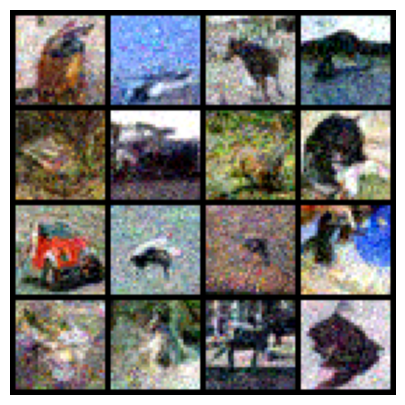

In [34]:
show_samples(m.sample(16))

===== EPOCH 91 =====


100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


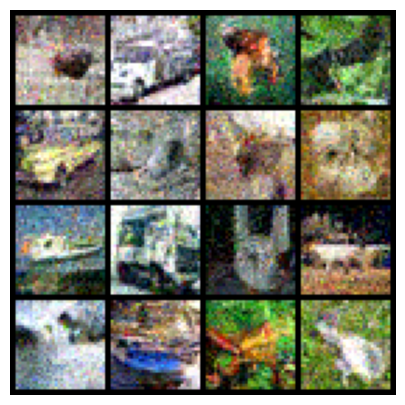

wandb: WARNING Data passed to `wandb.Image` should consist of values in the range [0, 255], image data will be normalized to this range, but behavior will be removed in a future version of wandb.


===== EPOCH 92 =====


100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


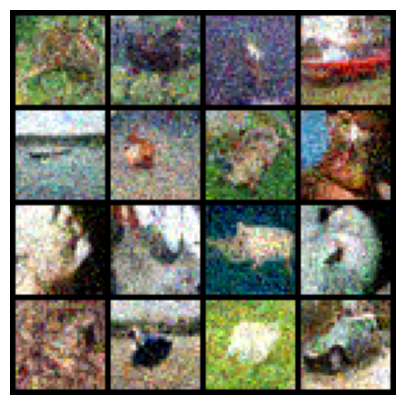

===== EPOCH 93 =====


100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


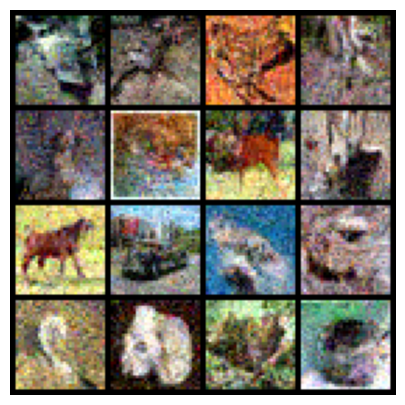

===== EPOCH 94 =====


100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


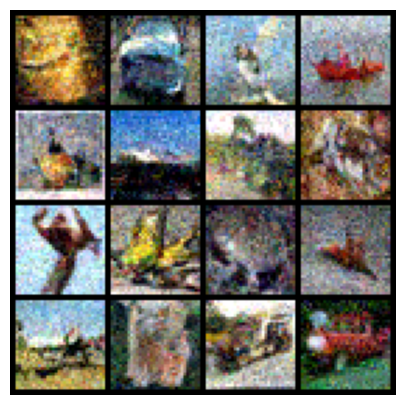

===== EPOCH 95 =====


100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


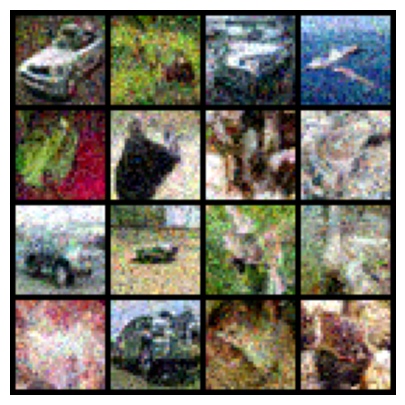

===== EPOCH 96 =====


100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


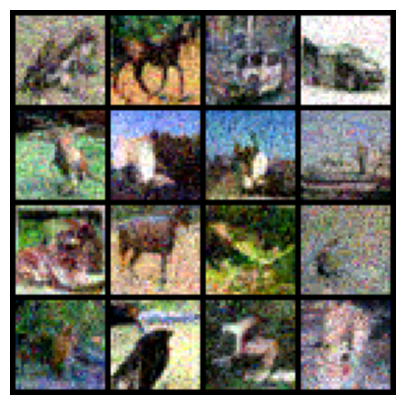

===== EPOCH 97 =====


100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


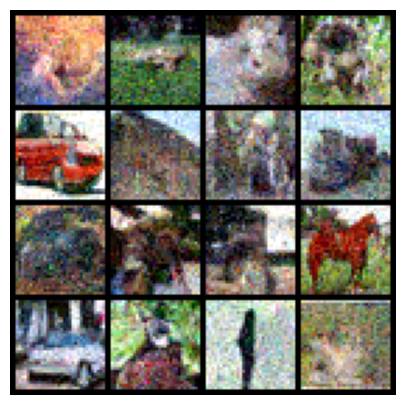

===== EPOCH 98 =====


100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


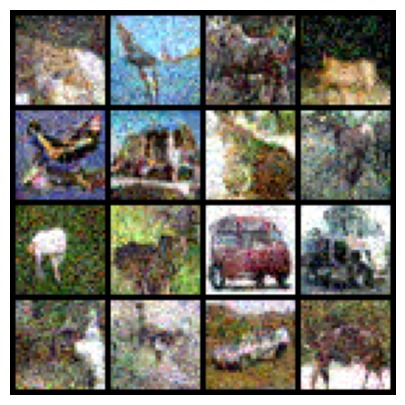

===== EPOCH 99 =====


100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


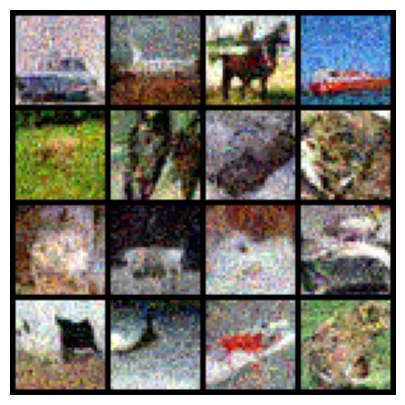

===== EPOCH 100 =====


100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


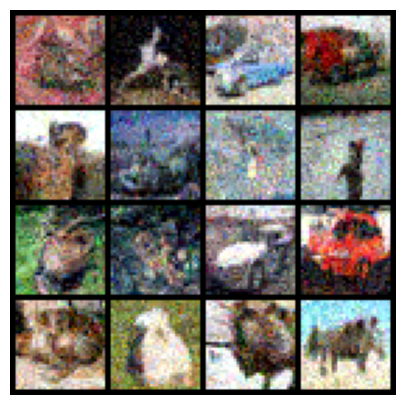

100%|██████████| 10/10 [11:32<00:00, 69.25s/it]
Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 228MB/s] 
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 300 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                  

{'frechet_inception_distance': 196.06957828937627, 'kernel_inception_distance_mean': 0.1300772476196289, 'kernel_inception_distance_std': 0.004470511242948238}


Kernel Inception Distance: 0.1300772476196289 ± 0.004470511242948238


In [35]:
train("ExperimentEMA_NumFilters128_BatchSize64_Epoch91_100_Kaggle", m, 91, 100, loader)